<div dir="rtl">
این فایل سومه و: 
صرف نظر کردیم از شمردن کلمات کامنتها .

کامنت های خنثی حذف شده

دیتاست بالانس شد

رکوردها شافل شدن که بهم بریزه و به ترتیب نباشه رکوردها

بعد داده ها به تست و ولید و ترین شکسته شدن

بعد برای مدل ها آماده سازی و ترین شده و تست شده هر مدل

اینجا ایپوک ۳ و سایز ۱۲۸ هست

f1 توی پای تورچ به ۹۱ درصد رسید. و تنسرفلو به ۹۰

</div>

# Introducing ParsBERT:
**ParsBERT (Transformer-based Model for Persian Language Understanding)** Is a monolingual language model based on Google's BERT architecture. This model is pre-trained on large Persian corpora with various writing styles from numerous subjects (e.g., scientific, novels, news, ...) with more than 3.9M documents, 73M sentences, and 1.3B words.

## Evaluation

ParsBERT is evaluated on three NLP downstream tasks: Sentiment Analysis (SA), Text Classification, and Named Entity Recognition (NER). 

ParsBERT outperformed all other language models, including multilingual BERT and other hybrid deep learning models for all tasks, improving the state-of-the-art performance in Persian language modeling.

## Results

The following table summarizes the F1 score obtained by ParsBERT V2.0 as compared to other models and architectures.



### Sentiment Analysis (SA) task

|           Dataset          |  ParsBERT | mBERT | 
|:--------------------------:|:---------:|:-----:|
|   Digikala User Comments   |   81.74*  | 80.74 |
|   SnappFood User Comments  |   88.12*  | 87.87 |       

Paper presenting ParsBERT: [arXiv:2005.12515](https://arxiv.org/abs/2005.12515)





# what are we going to do in our project?
***Bulid a SA Binary classification for DeepSentiPers using ParsBERT*** wich is a Transformer-based Model for Persian Language Understanding


# Preparing System

## check GPU

A GPU can be added by going to the menu and selecting one of the falowing 2:

  1- Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)
  <br/>
  2- Runtime 🡒  change runtime type 🡒 Hardware accelerator 🡒 (GPU)

In [ ]:
#The NVIDIA System Management Interface (nvidia-smi) is a command line utility, 
# intended to aid in the management and monitoring of NVIDIA GPU devices. 
!nvidia-smi 

Thu Jul  8 07:25:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install required packages

In [ ]:
!pip install -q transformers==3
!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 757kB 9.2MB/s 
     |████████████████████████████████| 1.2MB 34.3MB/s 
     |████████████████████████████████| 3.0MB 31.0MB/s 
     |████████████████████████████████| 901kB 50.9MB/s 
     |████████████████████████████████| 317kB 8.8MB/s 
     |████████████████████████████████| 1.4MB 43.5MB/s 
     |████████████████████████████████| 235kB 48.6MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 133kB 15.7MB/s 
     |████████████████████████████████| 245kB 14.3MB/s 


## Import required packages

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import requests
import os
import io
import re
import json
import copy
import collections

# Dataset

We are going to use [DeepSentiPers Dataset](https://github.com/JoyeBright/DeepSentiPers/tree/master/Dataset) from our base articale whici is presented on class. called [DeepSentiPers: Novel Deep Learning Models Trained Over Proposed Augmented Persian Sentiment Corpus](file:///C:/MCs/0_Term-03/KnowledgeBaseManagement/DeepSentiPers/DeepSentiPers_Art.pdf).
They proposed  2 Augmentated balanced dataset as "Balanced" and "Translation". We used both for our model apart and combine them as "BT Ds" without duplicate records, wich is use in this file.
<table style="width:100%">
  <tr>
    <th>Polarity</th>
    <th>-2</th>
    <th>-1</th>
    <th>0</th>
    <th>+1</th>
    <th>+2</th>
  </tr>
  <tr>
    <td>Original (SentiPers) DS</td>
    <td>28</td>
    <td>513</td>
    <td>2409</td>
    <td>1623</td>
    <td>988</td>
  </tr>
    <tr>
    <td>Balanced DS</td>
    <td>158</td>
    <td>937</td>
    <td>2000</td>
    <td>2000</td>
    <td>1928</td>
  </tr>
    <tr>
    <td>Translation DS</td>
    <td>56</td>
    <td>1026</td>
    <td>4818</td>
    <td>3246</td>
    <td>1976</td>
  </tr>
    <tr>
    <td>BT DS</td>
    <td>299</td>
    <td>1706</td>
    <td>3661</td>
    <td>3667</td>
    <td>3277</td>
  </tr>
</table>



## Load

In [ ]:
# Loading a Balanced Ds csv file from GitHub
url = "https://raw.githubusercontent.com/JoyeBright/DeepSentiPers/master/Dataset/balanced.csv" 
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
B_data = pd.read_csv(io.StringIO(download.decode('utf-8')))
B_data.set_axis(['comment', 'rate'], axis='columns', inplace=True)

# Printing out the first 5 rows of the dataframe
print('The first 5 rows of the dataset: \n', B_data.head())

# print data information
print('\n ________________________________________ \n\n'
  'Data information:\n')
B_data.info()

The first 5 rows of the dataset: 
                                              comment  rate
0  کارت‌های حافظه ای که معمولا بر روی گوشی‌های هو...     0
1  اندازه رزولوشن نمایشگر iPod دقیقا همانند iPhon...     0
2  اما صفحه نمایش دوربین فیلمبرداری JVC GZ-MG335،...     0
3  نهایتا، بر روی قاب پشتی گوشی نیز، دوربین به هم...     0
4  ایسوس در پایین این گوشی یک پورت ترکیبی قرار دا...     0

 ________________________________________ 

Data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  7022 non-null   object
 1   rate     7022 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 109.8+ KB


In [ ]:
# Loading a Translation DS csv file from GitHub
url = "https://raw.githubusercontent.com/JoyeBright/DeepSentiPers/master/Dataset/translation.csv" 
download = requests.get(url).content

T_data = pd.read_csv(io.StringIO(download.decode('utf-8')))
T_data.set_axis(['comment', 'rate'], axis='columns', inplace=True)

print('The first 5 rows of the dataset: \n', T_data.head())
print('\n ________________________________________ \n\n'
  'Data information:\n')
T_data.info()

The first 5 rows of the dataset: 
                                              comment  rate
0  کارتهای حافظه معمولاً در تلفنهای همراه به جای ...     0
1          وضوح نمایشگر iPod دقیقاً مشابه آیفون است.     0
2  اما صفحه نمایش JVC GZ-MG335 از نوع TFT 2.7 این...     0
3  سرانجام ، در پشت گوشی ، دوربین از یک فلاش بلند...     0
4  در انتهای گوشی ، ایسوس درگاهی را به نام MHL قر...     0

 ________________________________________ 

Data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14045 entries, 0 to 14044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  14045 non-null  object
 1   rate     14045 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 219.6+ KB


## Combine 2 datasets and remolve dublicate


In [ ]:
# Combine 2 datasets:
data = pd.concat([B_data, T_data])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 14044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  21067 non-null  object
 1   rate     21067 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 493.8+ KB


In [ ]:
# Remolve dublicate:
data = data.drop_duplicates(subset=['comment'])
print('The BT Ds information: \n')
data.info()

# Printing out the first 5 rows of the dataframe
print('\n -----------------------------------------------------\n'
      'The first 5 rows of the dataset: \n', data.head())

The BT Ds information: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12610 entries, 0 to 7021
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  12610 non-null  object
 1   rate     12610 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 295.5+ KB

 -----------------------------------------------------
The first 5 rows of the dataset: 
                                              comment  rate
0  کارت‌های حافظه ای که معمولا بر روی گوشی‌های هو...     0
1  اندازه رزولوشن نمایشگر iPod دقیقا همانند iPhon...     0
2  اما صفحه نمایش دوربین فیلمبرداری JVC GZ-MG335،...     0
3  نهایتا، بر روی قاب پشتی گوشی نیز، دوربین به هم...     0
4  ایسوس در پایین این گوشی یک پورت ترکیبی قرار دا...     0


In [ ]:
fig = go.Figure()

BT_groupby_rate = data.groupby('rate')['rate'].count()

fig.add_trace(go.Bar(
    x=list(sorted(BT_groupby_rate.index)),
    y=BT_groupby_rate.tolist(),
    text=BT_groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments in BT DS',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

## Preprocessing

The comments have different lengths based on words! We found out meaningful phrase in this Ds is 1 word length such as "عالی" and "عالیه", and the maximum length is 281, So we keept all records.

In [ ]:
unique_ratesB = list(sorted(data['rate'].unique()))
print(f'We have #{len(unique_ratesB)} in Blanced DS:: {unique_ratesB}')

We have #5 in Blanced DS:: [-2, -1, 0, 1, 2]


In [ ]:
BT_groupby_rate = data.groupby('rate')['rate'].count()
BT_groupby_rate

rate
-2     299
-1    1706
 0    3661
 1    3667
 2    3277
Name: rate, dtype: int64

### Binarization BT Ds Using NR approch


The given dataset has multiple emotions by default. However, for binary classifications, there must be just two groups, positive or negative. Since there are three classes of emotion, the following approaches have been proposed in [base article](https://arxiv.org/pdf/2004.05328.pdf):

1. NR: Removing neutral emotions
2. NP: Considering neutral emotions as positive
3. NN: Considering neutral emotions as negative

They use NR approch, but we prefer use NN for Blanced DS, and NR for both translation and BT DS.

To a binary form of negative (0) or positive (1) with a threshold. If the rate is greater than 0, it labeled as positive otherwise specified as negative.

In [ ]:
# remove the neutral (0 rate) recordes from Ds
data['rate'] = data['rate'].apply(lambda r: r if r != 0 else None)

data = data.dropna(subset=['rate'])
data = data.dropna(subset=['comment'])

data = data.drop_duplicates(subset=['comment'], keep='first')
data = data.reset_index(drop=True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  8949 non-null   object 
 1   rate     8949 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.0+ KB


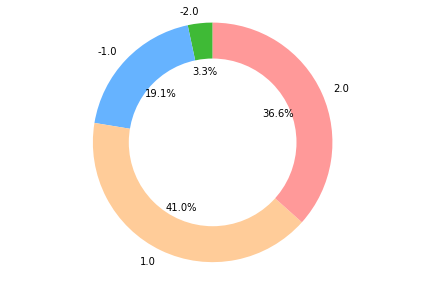

In [ ]:
# See the persentage of sentence in each categories
GroupbyRate = data.groupby('rate')['rate'].count()
GroupbyRate = dict(GroupbyRate)

labels = list(GroupbyRate.keys())
sizes = list(GroupbyRate.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
plt.show()

In [ ]:
def rate_to_label(rate):
    if rate < 1:
        return 'negative'
    else:
      return 'positive'


In [ ]:
data['label'] = data['rate'].apply(lambda r: rate_to_label(r))
labels = list(sorted(data['label'].unique()))

data.head()

,comment,rate,label
0,همچنین یک برنامه بسیار کاربردی در جهت ارائه نی...,1.0,positive
1,این استاندارد بدین معناست که این دستگاه در برا...,1.0,positive
2,حقیقتا زمانی که آن دوربین معرفی شد توانایی زوم...,1.0,positive
3,این گوشی از رابط کاربری سونی اریکسون TimeScape...,1.0,positive
4,در تست مرورگری اینترنت از طریق Wi-Fi با روشنای...,1.0,positive


In [ ]:
BTgroupby_label = data.groupby('label')['label'].count()
BTgroupby_label = dict(BTgroupby_label)
print(BTgroupby_label)

{'negative': 2005, 'positive': 6944}


In [ ]:
# See the data of sentence in each labeles
fig = go.Figure()

fig.add_trace(go.Bar(
    x=list(BTgroupby_label.keys()),
    y= list(BTgroupby_label.values()),
    text= list(BTgroupby_label.values()),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Lable',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

The Dataset now is unblanced.

### Cleaning 
is the final step in this section, and becase **DeepSentiPers** had five different preprocessing steps were applied to all the sentences (Normalization, Punctuation rmoval, Single character removal, Digits removal and Lemmatization), so Our cleaned method includes these steps:
- fixing unicodes
- removing specials like an email, url, new lines, ...
- cleaning HTMLs
- removing emojis

In [ ]:
import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,                 # fix various unicode errors
        to_ascii=False,                   # transliterate to closest ASCII representation
        lower=True,                       # lowercase text
        no_line_breaks=True,              # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                     # replace all URLs with a special token
        no_emails=True,                   # replace all email addresses with a special token
        no_phone_numbers=True,            # replace all phone numbers with a special token
        no_numbers=False,                 # replace all numbers with a special token
        no_digits=False,                  # replace all digits with a special token
        no_currency_symbols=True,         # replace all currency symbols with a special token
        no_punct=False,                   # remove punctuations
        replace_with_url="",              # instead of removing URL replace them by noyhing
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",  
        #lang="en"                       # set to 'de' for German special handling
        # So far, only English and German are fully supported. It should work for the majority of western languages.
    )


    # cleaning htmls
    text = cleanhtml(text) 
   
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)
data.head()

,comment,rate,label,cleaned_comment
0,همچنین یک برنامه بسیار کاربردی در جهت ارائه نی...,1.0,positive,همچنین یک برنامه بسیار کاربردی در جهت ارائه نی...
1,این استاندارد بدین معناست که این دستگاه در برا...,1.0,positive,این استاندارد بدین معناست که این دستگاه در برا...
2,حقیقتا زمانی که آن دوربین معرفی شد توانایی زوم...,1.0,positive,حقیقتا زمانی که آن دوربین معرفی شد توانایی زوم...
3,این گوشی از رابط کاربری سونی اریکسون TimeScape...,1.0,positive,این گوشی از رابط کاربری سونی اریکسون timescape...
4,در تست مرورگری اینترنت از طریق Wi-Fi با روشنای...,1.0,positive,در تست مرورگری اینترنت از طریق wi-fi با روشنای...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   comment          8949 non-null   object 
 1   rate             8949 non-null   float64
 2   label            8949 non-null   object 
 3   cleaned_comment  8949 non-null   object 
dtypes: float64(1), object(3)
memory usage: 279.8+ KB


In [ ]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,همچنین یک برنامه بسیار کاربردی در جهت ارائه نی...,positive
1,این استاندارد بدین معناست که این دستگاه در برا...,positive
2,حقیقتا زمانی که آن دوربین معرفی شد توانایی زوم...,positive
3,این گوشی از رابط کاربری سونی اریکسون timescape...,positive
4,در تست مرورگری اینترنت از طریق wi-fi با روشنای...,positive


In [ ]:
print(f'We have #{len(labels)} labels: {labels}')

We have #2 labels: ['negative', 'positive']


### Handling Unbalanced Data
for making things simple. We cut the dataset randomly based on the fewer label, the negative class.

In [ ]:
negative_data = data[data['label'] == 'negative']
positive_data = data[data['label'] == 'positive']

cutting_point = min(len(negative_data), len(positive_data))

if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

new_data = pd.concat([negative_data, positive_data])
new_data = new_data.sample(frac=1).reset_index(drop=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010 entries, 0 to 4009
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4010 non-null   object
 1   label    4010 non-null   object
dtypes: object(2)
memory usage: 62.8+ KB


In [ ]:
# See the data number of sentence in each category and is it balanced?
GroupbyLabel = new_data.groupby('label')['label'].count()

GroupbyLabel = dict(GroupbyLabel)
print(GroupbyLabel)

{'negative': 2005, 'positive': 2005}


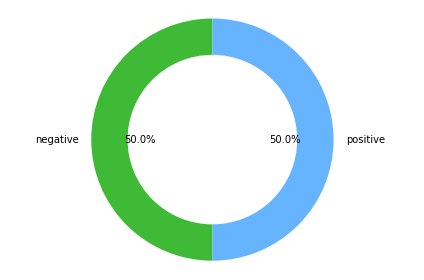

In [ ]:
labels = list(GroupbyLabel.keys())
sizes = list(GroupbyLabel.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
plt.show()

The dataset is balanced, so we are going to fine-tuning model

# Train,Validation,Test split

We need to split the balanced cleaned dataset into train, valid and test sets due to size of the data. 

We have considered a rate of **0.3** for *valid*, **0.1** for *test* sets. For splitting, we use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [ ]:
new_data = data
new_data = new_data.sample(frac=1).reset_index(drop=True) # we shuffle the order of the DataFrame's rows,
                                                          # so that all Type's are mixed.
new_data.info()
new_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  8949 non-null   object
 1   label    8949 non-null   object
dtypes: object(2)
memory usage: 140.0+ KB


,comment,label
0,قطعا این فن‌آوری کاملاً مؤثرتر از فن آوری های ...,positive
1,نلفن هوشمند با امکانات بالا در عين حال سبک نازک.,positive
2,از دیدن او واقعاً تعجب کردم,positive
3,طراحی طراحی از نظر کیفیت طراحی می توان گفت هوا...,positive
4,یکی دیگر از قابلیت های کلیدی این مدل سرعت تصوی...,positive


In [ ]:
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.3, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(5637, 3)
(2417, 3)
(895, 3)


In [ ]:
new_data.head()

,comment,label,label_id
0,قطعا این فن‌آوری کاملاً مؤثرتر از فن آوری های ...,positive,1
1,نلفن هوشمند با امکانات بالا در عين حال سبک نازک.,positive,1
2,از دیدن او واقعاً تعجب کردم,positive,1
3,طراحی طراحی از نظر کیفیت طراحی می توان گفت هوا...,positive,1
4,یکی دیگر از قابلیت های کلیدی این مدل سرعت تصوی...,positive,1


First of all, we follow the model using *PyTorch*, and next, do the same processes using *TensorFlow* and finally use the ParsBERT script to do all the things once.

![BERT INPUTS](https://humboldt-wi.github.io/blog/img/seminar/bert/bert_input.png)

As you know, the BERT model input is a combination of 3 embeddings.
- Token embeddings: WordPiece token vocabulary (WordPiece is another word segmentation algorithm, similar to BPE)
- Segment embeddings: for pair sentences [A-B] marked as $E_A$ or $E_B$ mean that it belongs to the first sentence or the second one.
- Position embeddings: specify the position of words in a sentence

## Using PyTorch

### Import required packages

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

### Configuration

####Select GPU
A GPU can be added by going to the menu and selecting one of the falowing 2:

  1- Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)
  <br/>
  2- Runtime 🡒  change runtime type 🡒 Hardware accelerator 🡒 (GPU)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


#### General config

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/MCs/KBM/bert-fa-base-uncased-sentiment/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())


{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



### Input Embeddings

In [ ]:
idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['comment']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_comment}\n{sample_label}')

Sample: 
فقط ميتونم بگم فوق العاده ست.
positive


In [ ]:
tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  Comment: فقط ميتونم بگم فوق العاده ست.
   Tokens: فقط ميتونم بگم فوق العاده ست .
Token IDs: [3765, 59767, 4957, 2015, 18757, 4692, 8505, 3705, 1012]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  3765, 59767,  4957,  2015, 18757,  4692,  8505,  3705,  1012,
             4,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


### Dataset

In [ ]:
class BTDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for DeepSentiPers. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = BTDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['پردازنده 2 گیگاهرتزی که بسیار مناسب تر از رقبای خود در این محدوده قیمت (کابل htc wilde fire s) کابل 3-otg است که می تواند ماوس را به هم متصل کند (من خودم از این کابل استفاده می کنم) 4-صدای خوب بالا پایان x برای علاقه مندان به موسیقی با یک دوربین خوب 5 مگاپیکسلی که کیفیت رضایت بخش را ارائه می دهد', 'واقعاً هم ازش راضي\u200c هستم.', 'به نظر می رسد باتری در این سطح برای یک تلفن ضعیف است.', 'صادقانه می توانم بگویم که تا به امروز هیچ تبلت دیگری چنین نرم افزاری office با این قدرت edith ندارد.', 'در مورد عملکرد ، همانطور که گفتیم فوکوس اتوماتیک در واقع بهترین نیست ، اما همچنین شاتر لاگ وجود ندارد که به محض فشار دکمه شاتر عکس بگیرید.', 'اگر صفحه\u200cنمایش 3.5 اینچی داشته باشد بسیار بهتر خواهد بود.', 'در کنار این سیستم عامل فوق\u200cالعاده، چیزی که باعث نهایت لذت از کار با این گوشی خواهد شد، رابط کاربری بسیار محبوب htc یعنی htc sense plus می\u200cباشد.', 'اما وقتی لرزش شروع شد وقتی کمی گرم شد ، دوباره به صفحه 

In [ ]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids'])


### Model

During the implementation of the model, sometime, you may be faced with this kind of error. It said you used all the Cuda-Memory for solving. There are many ways for the simple one is to clear the Cuda cache memory!

![Cuda-Error](https://res.cloudinary.com/m3hrdadfi/image/upload/v1599979552/kaggle/cuda-error_iyqh4o.png)


**Simple Solution**
```python
import torch, gc

gc.collect()
torch.cuda.empty_cache()

!nvidia-smi
```

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Thu Jul  8 07:26:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
# sample data output

sample_data_comment = sample_data['comment']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)


# outputs = F.softmax(
#     pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids), 
#     dim=1)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(outputs[:5, :])
print(preds[:5])

tensor([[ 0.2476, -0.0235],
        [ 0.3669,  0.0720],
        [ 0.1096, -0.2263],
        [-0.0320, -0.0573],
        [-0.2423, -0.2445]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0, 0, 0, 0, 0], device='cuda:0')


### Training

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)


Epoch: 3/3...Step: 1000...Train Loss: 0.055986...Train Acc: 0.985...Valid Loss: 0.331594...Valid Acc: 0.901...
Validation loss decreased (inf --> 0.331594).  Saving model ...



### Prediction

In [ ]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)


(895,) (895, 2)


In [ ]:
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.911502385099557

              precision    recall  f1-score   support

    negative       0.86      0.74      0.79       201
    positive       0.93      0.97      0.95       694

    accuracy                           0.91       895
   macro avg       0.89      0.85      0.87       895
weighted avg       0.91      0.91      0.91       895



## Using TensorFlow

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features

import tensorflow as tf

### Configuration

In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/drive/MyDrive/MCs/KBM/bert-fa-base-uncased-sentiment/TensorFlow_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

#!if [ -d 'GDrive/My Drive/CarCrashDetection/Dataset/train/accident' ]; then echo "Directory accident in train already exist" ; else mkdir 'GDrive/My Drive/CarCrashDetection/Dataset/train/accident' && echo "Directory accident in train created"; fi




In [ ]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



### Input Embeddings / Dataset

In [ ]:
class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)
        
        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]
        
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    
    features = glue_convert_examples_to_features(
        examples, 
        tokenizer, 
        maxlen, 
        output_mode=output_mode, 
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features
    
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

In [ ]:
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=128)
valid_dataset_base, valid_examples = make_examples(tokenizer, x_valid, y_valid, maxlen=128)

test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128, is_tf_dataset=False)

In [ ]:
for value in train_dataset_base.take(1):
    print(f'     input_ids: {value[0]["input_ids"]}')
    print(f'attention_mask: {value[0]["attention_mask"]}')
    print(f'token_type_ids: {value[0]["token_type_ids"]}')
    print(f'        target: {value[1]}')

     input_ids: [    2  7639     1 45211  2800  3177  4006  3088  2791 12060  2847  2786
  2802  6510  3377  1006  7926 19409 32969  2033 29220  1044  1007  7926
     1  1011 35773  2053  2806  2800  2793 25408 21708  2803  2789  2820
  6251  3054  1006  2842  6558  2791  2802  7926  2988  2793  5400  1007
     1  1011  5466  4124  3683  3559  1049  2831  5351 16528  2789  4020
  2799  2829  4834  4124     1 10316  2800  4589  6949  3108  2803  3625
  2793  3890     4     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
attention_mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)
valid_dataset = get_training_dataset(valid_dataset_base, VALID_BATCH_SIZE)

train_steps = len(train_examples) // TRAIN_BATCH_SIZE
valid_steps = len(valid_examples) // VALID_BATCH_SIZE

train_steps, valid_steps

(352, 151)

### Model

In [ ]:
def build_model(model_name, config, learning_rate=3e-5):
    model = TFBertForSequenceClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [ ]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [ ]:
%%time

r = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    epochs=EPOCHS,
    verbose=1)

final_accuracy = r.history['val_accuracy']
print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

Epoch 1/3
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
352/352 [==============================] - 193s 504ms/step - loss: 0.3169 - accuracy: 0.8629 - val_loss: 0.2420 - val_accuracy: 0.8986
Epoch 2/3
352/352 [==============================] - 175s 496ms/step - loss: 0.1599 - accuracy: 0.9384 - val_loss: 0.2616 - val_accuracy: 0.9044
Epoch 3/3
352/352 [==============================] - 175s 496ms/step - loss: 0.0844 - accuracy: 0.9707 - val_loss: 0.3468 - val_accuracy: 0.8982
FINAL ACCURACY MEAN:  0.9003863135973612
CPU times: user 2min 55s, sys: 1min 3s, total: 3min 58s
Wall time: 9min 2s


In [ ]:
# save the model
model.save_pretrained(os.path.dirname(OUTPUT_PATH))

### Evaluation / Prediction

In [ ]:
ev = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
print()
print(f'Evaluation: {ev}')
print()

predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print()
print(classification_report(ytest, ypred, target_names=labels))
print()

print(f'F1: {f1_score(ytest, ypred, average="weighted")}')

56/56 [==============================] - 8s 145ms/step - loss: 0.3243 - accuracy: 0.9017

Evaluation: [0.3243485987186432, 0.9016759991645813]


              precision    recall  f1-score   support

    negative       0.77      0.81      0.79       201
    positive       0.94      0.93      0.94       694

    accuracy                           0.90       895
   macro avg       0.85      0.87      0.86       895
weighted avg       0.90      0.90      0.90       895


F1: 0.9026722250152046


# Source
[Loading a csv file from GitHub in Python](https://medium.com/towards-entrepreneurship/importing-a-csv-file-from-github-in-a-jupyter-notebook-e2c28e7e74a5)